In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pydaptivefiltering as pdf 

[DLCLLMS] Completed in 188.011 ms | blocks=1500 | used=12000/12000


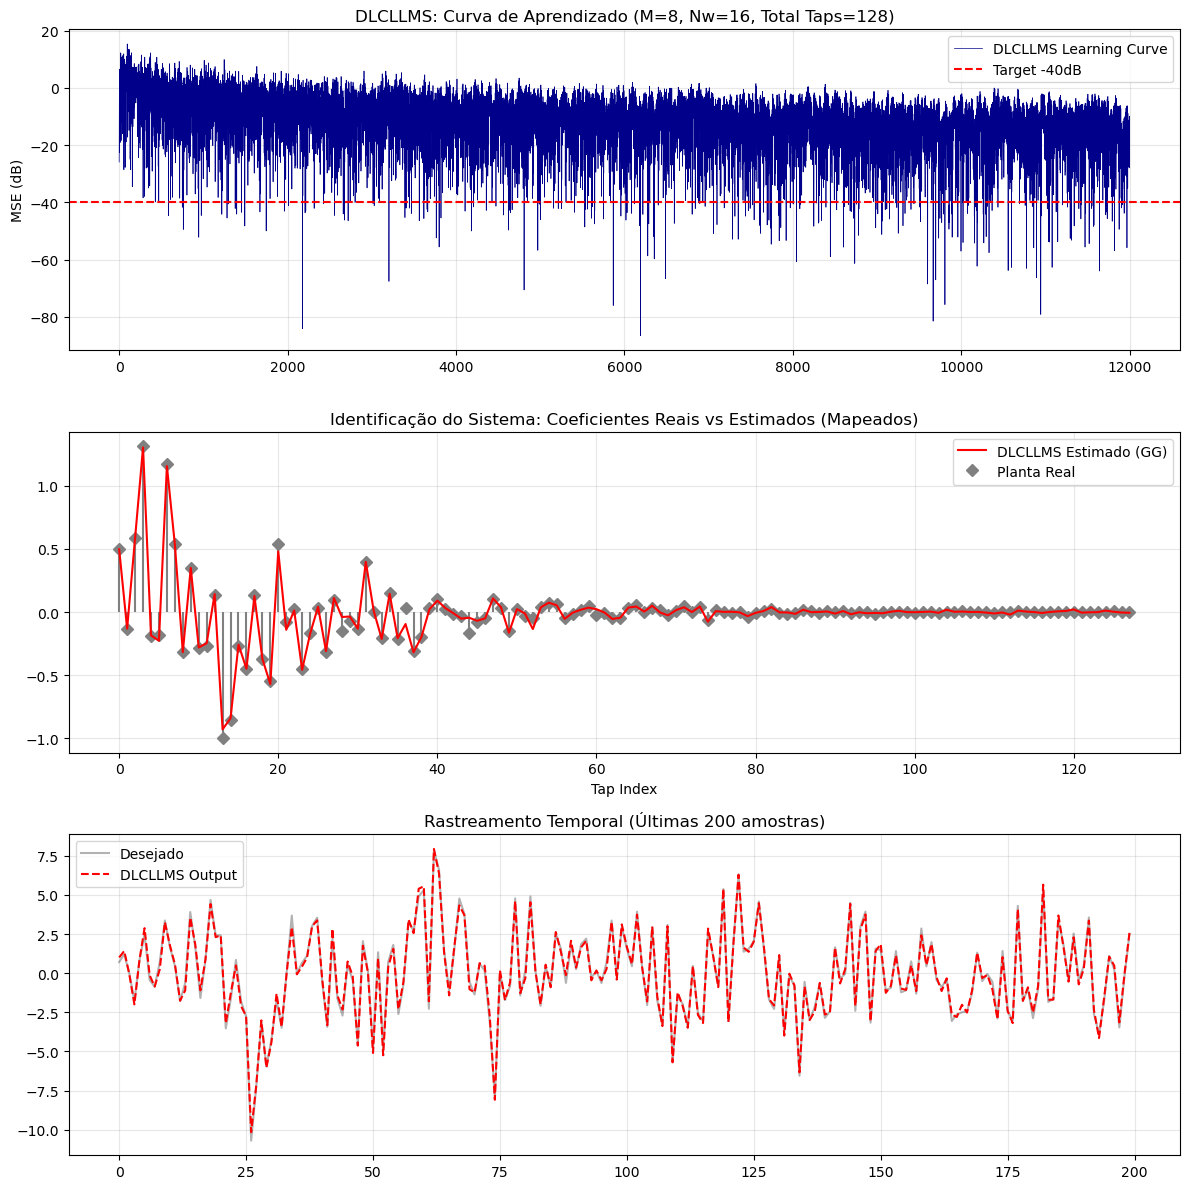

MSE Final: 7.69e-02


In [2]:
def test_dlcllms_notebook():
    # 1. Parâmetros de Configuração
    N = 12000          # O DLCLLMS precisa de mais iterações para estabilizar o mapeamento
    M = 8              # Número de sub-bandas
    Nw = 16            # Ordem em cada sub-banda (Filtro fullband terá M*Nw = 128 taps)
    step_size = 0.05        # Passo de adaptação
    nyquist_len = 16   # Tamanho do filtro de Nyquist para o mapeamento
    
    # 2. Criar Planta Desconhecida (128 taps para casar com M*Nw)
    # Criamos uma resposta ao impulso FIR aleatória
    np.random.seed(42)
    h_real = np.random.randn(M * Nw) * np.exp(-0.05 * np.arange(M * Nw))
    
    # 3. Gerar Sinais
    x = np.random.randn(N)
    d_clean = np.convolve(x, h_real, mode='full')[:N]
    noise_floor = 0.001 * np.random.randn(N) # -60dB de ruído
    d = d_clean + noise_floor
    
    # 4. Instanciar o DLCLLMS
    # Note que Nw aqui é o filter_order passado para a classe
    filt = pdf.DLCLLMS(
        filter_order=Nw,
        n_subbands=M,
        step_size=step_size,
        gamma=1e-2,
        a=0.01,
        nyquist_len=nyquist_len
    )
    
    # 5. Executar Otimização
    res = filt.optimize(x, d, verbose=True)
    
    y = res.outputs
    e = res.errors
    w_final = res.coefficients[-1] # Último filtro fullband equivalente mapeado
    
    # 6. Métricas e Gráficos
    mse_db = 10 * np.log10(e**2 + 1e-12)
    
    plt.figure(figsize=(12, 12))
    
    # Subplot 1: Erro Quadrático Médio
    plt.subplot(3, 1, 1)
    plt.plot(mse_db, color='darkblue', lw=0.5, label='DLCLLMS Learning Curve')
    plt.axhline(y=-40, color='r', linestyle='--', label='Target -40dB')
    plt.title(f"DLCLLMS: Curva de Aprendizado (M={M}, Nw={Nw}, Total Taps={M*Nw})")
    plt.ylabel("MSE (dB)")
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Subplot 2: Comparação de Coeficientes (Mapeamento)
    plt.subplot(3, 1, 2)
    plt.stem(h_real, linefmt='gray', markerfmt='D', label='Planta Real', basefmt=" ")
    plt.plot(w_final, 'r', label='DLCLLMS Estimado (GG)')
    plt.title("Identificação do Sistema: Coeficientes Reais vs Estimados (Mapeados)")
    plt.xlabel("Tap Index")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Subplot 3: Zoom no Rastreamento Temporal
    plt.subplot(3, 1, 3)
    plt.plot(d[-200:], 'k', alpha=0.3, label='Desejado')
    plt.plot(y[-200:], 'r--', label='DLCLLMS Output')
    plt.title("Rastreamento Temporal (Últimas 200 amostras)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    print(f"MSE Final: {np.mean(e[-500:]**2):.2e}")

# Executar
test_dlcllms_notebook()

# Teste 2

In [4]:
# 1. Configurações da Simulação
np.random.seed(42)
n_samples = 4000
M = 4          # Número de subbandas
Nw = 12         # Ordem do filtro em cada subbanda
fullband_len = M * Nw

In [5]:
# 2. Criar a "Planta" Desconhecida (Filtro que queremos descobrir)
# Criamos um filtro FIR passa-baixas para simular um sistema real
w_unknown = np.zeros(fullband_len)
w_unknown[int(fullband_len/4):int(fullband_len/2)] = np.hamming(int(fullband_len/4))
w_unknown /= np.linalg.norm(w_unknown)

In [6]:
# 3. Gerar Sinais de Entrada e Desejado
x = np.random.randn(n_samples) # Ruído branco de entrada

# Sinal desejado d[n] = (x * planta) + ruído de medição
d_clean = np.convolve(x, w_unknown, mode='full')[:n_samples]
noise = 0.001 * np.random.randn(n_samples)
d = d_clean + noise

In [7]:
# 4. Instanciar e rodar o DLCLLMS
# Note: Certifique-se que a classe DLCLLMS foi definida em uma célula anterior
flt = pdf.DLCLLMS(
    filter_order=Nw,
    n_subbands=M,
    step_size=0.2,       # Passo de convergência (mu)
    gamma=1e-3,     # Estabilização
    a=0.1,          # Suavização da potência
    nyquist_len=32  # Nfd (maior para melhor reconstrução fullband)
)

results = flt.optimize(x, d, verbose=True)
y = results.outputs
e = results.errors

[DLCLLMS] Completed in 43.507 ms | blocks=1000 | used=4000/4000


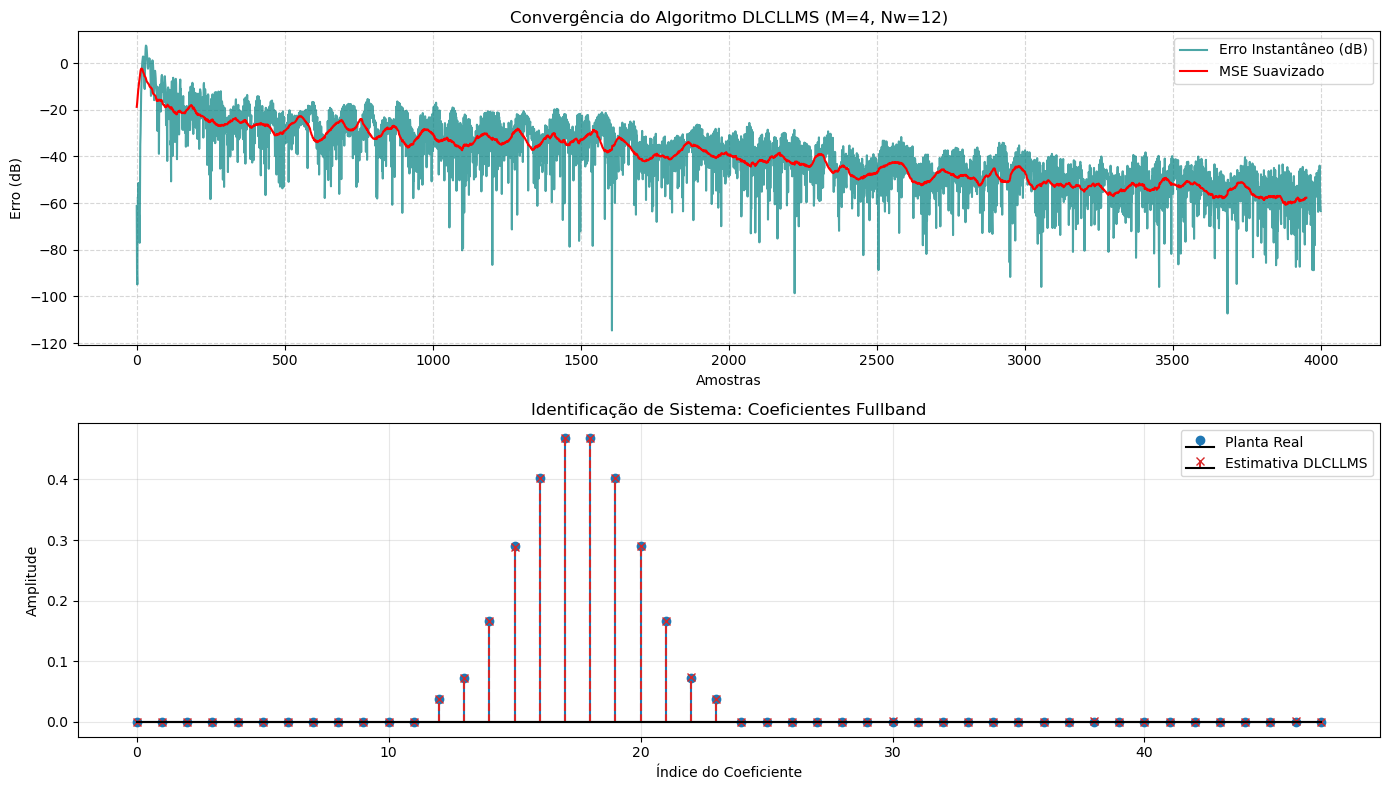

MSE Final Médio: 0.00000637


In [8]:
# 5. Visualização de Resultados
plt.figure(figsize=(14, 8))

# Subplot 1: Curva de Aprendizado (MSE em dB)
plt.subplot(2, 1, 1)
mse_db = 10 * np.log10(e**2 + 1e-12)
plt.plot(mse_db, color='teal', alpha=0.7, label='Erro Instantâneo (dB)')
# Média móvel para suavizar a curva de erro
plt.plot(np.convolve(mse_db, np.ones(50)/50, mode='valid'), color='red', label='MSE Suavizado')
plt.title(f"Convergência do Algoritmo DLCLLMS (M={M}, Nw={Nw})")
plt.xlabel("Amostras")
plt.ylabel("Erro (dB)")
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()

# Subplot 2: Comparação de Coeficientes
plt.subplot(2, 1, 2)
w_final = results.coefficients[-1] # Último filtro estimado
plt.stem(w_unknown, linefmt='C0-', markerfmt='C0o', label="Planta Real", basefmt="k")
plt.stem(w_final, linefmt='C3--', markerfmt='C3x', label="Estimativa DLCLLMS", basefmt="k")
plt.title("Identificação de Sistema: Coeficientes Fullband")
plt.xlabel("Índice do Coeficiente")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Métricas Finais
print(f"MSE Final Médio: {np.mean(e[-200:]**2):.8f}")